# Effecient Neural Network from Scratch
**Vectorized implementation with regularization, mini-batches, and Adam optimizer**
   
by: ***Abdallah Mahmoud Elsayed***

In [146]:
# import useful libraries

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import time

In [149]:
# Neural Network Class
class NN():
    def __init__(self, X, Y, layers_dims=[64,64,1], optimizer=True, learning_rate=0.33, mini_batch_size=64,
                 num_iterations=1000, lambd=0, beta1=0.9, beta2=0.999, print_cost=False, seed=0):
        self.parameters = {}
        self.X = X
        self.Y = Y
        self.layers_dims = [X.shape[0]] + layers_dims
        self.learning_rate = learning_rate
        self.mini_batch_size = mini_batch_size
        self.beta1 = beta1
        self.beta2 = beta2
        self.optimizer = optimizer
        self.lambd = lambd
        self.num_iterations = num_iterations
        self.print_cost = print_cost
        self.costs = []
        self.seed = seed
        np.random.seed(seed)
        
        
    def initial_params(self, layers_dims):
        """
        Initialize the parameters for the neural network
        
        Input:
            layer_dims: list containing size of each layer
        Returns:
            parameters: dictionary containing parameters (W1 W2 b2 ...)
        """
        
        np.random.seed(1)
        parameters = {}
        L = len(layers_dims)
        
        for l in range(1, L):
            parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1]) #* 0.01
            parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
            assert(parameters['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
            assert(parameters['b' + str(l)].shape == (layers_dims[l], 1))
        return parameters
    
    
    def initial_adam(self, params):
        """
        This function initialize parameters for Adam optimizer
        
        Inputs:
        
        Returns:
        """
        
        L = len(params)//2
        v = {}
        s = {}
        
        for l in range(1, L+1):
            v['dW'+str(l)] = np.zeros(params['W'+str(l)].shape)
            v['db'+str(l)] = np.zeros(params['b'+str(l)].shape)
            
            s['dW'+str(l)] = np.zeros(params['W'+str(l)].shape)
            s['db'+str(l)] = np.zeros(params['b'+str(l)].shape)
            
        return v, s
    
    
    def sigmoid(self, Z):
        """
        Sigmoid function
        Inputs:
            z: numpy array
        Returns:
            A: sigmoid(z)
        """
        
        A = 1/(1+np.exp(-Z))
        return A
    
    
    def sigmoid_backward(self, dA, cache):
        """"
        Sigmoid backword (derivative)
        
        Inputs:
            dA: post-activation gradient, of any shape
            cache: 'Z' where we store for computing backward propagation efficiently
        Returns:
            dZ: Gradient of the cost with respect to Z
        """
        
        Z = cache

        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)    
        return dZ
    
    
    def relu(self, Z):
        """
        ReLU function
        
        Inputs:
            Z: Output of the linear layer, of any shape
        Returns:
            A: Post-activation parameter, of the same shape as Z
        """
        A = np.maximum(0,Z)

        return A


    def relu_backward(self, dA, cache):
        """
        Implement the backward propagation for a single ReLU unit.

        Inputs:
            dA -- post-activation gradient, of any shape
            cache -- 'Z' where we store for computing backward propagation efficiently
        Returns:
            dZ -- Gradient of the cost with respect to Z
        """

        Z = cache
        dZ = np.array(dA, copy=True)

        # When z <= 0, you should set dz to 0 as well. 
        dZ[Z <= 0] = 0
        return dZ

    
    def forward_propagation(self, X, parameters):
        """
        Implement the forward path
        
        Inputs:
            X: numpy array of shape (input size, number of examples)
        Returns:
            AL: Yhat
            cache: dictionary containing caches (Z, A, b)
        """
        
        L = len(parameters)//2
        A = X
        cache = {}
        
        for l in range(1, L):
            cache['A'+str(l-1)] = A
            Z = parameters['W'+str(l)].dot(A) + parameters['b'+str(l)]
            A = self.relu(Z)
            cache['Z'+str(l)] = Z
            cache['W'+str(l)] = parameters['W'+str(l)]
            
        Z = parameters['W'+str(L)].dot(A) + parameters['b'+str(L)]
        AL = self.sigmoid(Z)

        cache['Z'+str(L)] = Z
        cache['A'+str(L-1)] = A
        cache['W'+str(L)] = parameters['W'+str(L)]
        
        return AL, cache
    
    
    def backword_propagation(self, AL, Y, caches):
        """
        Performs back propagation of multi-layer neural network

        Inputs: 
            AL, Y, memory (from the forward propagation)
        Returns:
            grads (errors)
        """
        
        grads = {}
        L = len(caches)//3
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        
        
        dAL = -Y/AL + (1-Y)/(1-AL)
        
        dZ = self.sigmoid_backward(dAL, caches['Z' + str(L)])
        grads['dA' + str(L-1)] = caches['W' + str(L)].T.dot(dZ)
        grads['dW' + str(L)] = 1/m * dZ.dot(caches['A'+str(L-1)].T)
        grads['dW' + str(L)] = grads['dW' + str(L)] + (self.lambd/m) * caches['W'+str(L)]
        grads['db' + str(L)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        
        for l in range(L-1, 0, -1):
            dZ = self.relu_backward(grads['dA'+str(l)], caches['Z' + str(l)])
            grads['dA' + str(l-1)] = caches['W' + str(l)].T.dot(dZ)
            grads['dW' + str(l)] = 1/m * dZ.dot(caches['A'+str(l-1)].T)
            grads['dW' + str(l)] = grads['dW' + str(l)] + (self.lambd/m) * caches['W'+str(l)]
            grads['db' + str(l)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
            
        return grads
    
    
    def update_params(self, params, grads):
        """
        Updates the parameters
        
        Inputs:
            params: the parameters
            grads: errors from the backword path
            
        Returns:
            The updated parameters
        """
        
        parameters = params.copy()
        L = len(params)//2
        
        for l in range(L):
            parameters['W'+str(l+1)] -= self.learning_rate * grads['dW'+str(l+1)]
            parameters['b'+str(l+1)] -= self.learning_rate * grads['db'+str(l+1)]
        
        return parameters
    
    
    def update_params_adam(self, params, grads, v, s, t):
        """
        Updates parameters using Adam optimizer
        
        Inputs:
            params: the parameters
            grads: errors from the backword path
            v: Adam variable, moving average of the first gradient, python dictionary
            s: Adam variable, moving average of the squared gradient, python dictionary
            t: Adam variable, counts the number of taken steps
            
        Returns:
            parameters -- python dictionary containing your updated parameters 
            v: The updated Adam variable, moving average of the first gradient, python dictionary
            s: The updated Adam variable, moving average of the squared gradient, python dictionary
        
        """
        parameters = params.copy()
        L = len(params)//2
        
        v_corrected = {}
        s_corrected = {}
        
        for l in range(1, L+1):
            
            v["dW" + str(l)] = self.beta1 * v["dW" + str(l)] + (1-self.beta1) * grads['dW'+str(l)]
            v["db" + str(l)] = self.beta1 * v["db" + str(l)] + (1-self.beta1) * grads['db'+str(l)]
            
            v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1-self.beta1**t)
            v_corrected["db" + str(l)] = v["db" + str(l)] / (1-self.beta1**t)
            
            s["dW" + str(l)] = self.beta2 * s["dW" + str(l)] + (1-self.beta2) * grads['dW'+str(l)]**2
            s["db" + str(l)] = self.beta2 * s["db" + str(l)] + (1-self.beta2) * grads['db'+str(l)]**2
        
            s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1-self.beta2**t)
            s_corrected["db" + str(l)] = s["db" + str(l)] / (1-self.beta2**t)
        
            parameters['W'+str(l)] -= self.learning_rate * ((v_corrected['dW'+str(l)]) / (np.sqrt(s_corrected['dW'+str(l)])+1e-12))
            parameters['b'+str(l)] -= self.learning_rate * ((v_corrected['db'+str(l)]) / (np.sqrt(s_corrected['db'+str(l)])+1e-12))
    
        return parameters, v, s
    
   
    def random_mini_batches(self):
        """
        This function creates a list of random minibatches from (X, Y)
        
        Inputs:
            None
        Returns:
            mini_batches: list containing the created mini batches 
        """
        np.random.seed(self.seed)
                
        m = self.X.shape[1]
        mini_batches = []
        
        permutation = list(np.random.permutation(m))
        X_shuffled = self.X[:, permutation]
        Y_shuffled = self.Y[:, permutation].reshape((1, m))
        
        num_complete_mini_batches = int(m/self.mini_batch_size)
        
        for k in range(num_complete_mini_batches):
            x = X_shuffled[:, self.mini_batch_size*k : self.mini_batch_size*(k+1)]
            y = Y_shuffled[:, self.mini_batch_size*k : self.mini_batch_size*(k+1)]
            
            mini_batches.append((x, y))
            
        if m%self.mini_batch_size !=0:
            x = X_shuffled[:, num_complete_mini_batches*self.mini_batch_size:]
            y = Y_shuffled[:, num_complete_mini_batches*self.mini_batch_size:]
            
            mini_batches.append((x, y))
            
        return mini_batches 
        
        
    def train(self, params=None):
        """
        This function trains a deep neural network model
        
        Inputs:
            params: if given, it will be used as the initial parameters
            
        Returns:
            None
        """
        m = self.X.shape[1]
        costs = []
        t = 0
        
        if params != None:
            self.parameters = params
        else:
            self.parameters = self.initial_params(self.layers_dims)
        
        if self.optimizer:
            v, s = self.initial_adam(self.parameters)
           
        
        for i  in range(self.num_iterations):
            self.seed+=1
            mini_batches = self.random_mini_batches()
            total_cost = 0
            
            for mini_batch in mini_batches:
                x, y = mini_batch
            
                AL, caches = self.forward_propagation(x, self.parameters)
                
                total_cost += self.cost_L2(AL, y)
                
                grads = self.backword_propagation(AL, y, caches)
                
                if self.optimizer:
                    t += 1
                    self.parameters, v, s = self.update_params_adam(self.parameters, grads, v, s, t)
                else:
                    self.parameters = self.update_params(self.parameters, grads, self.learning_rate)
                
            
            avg_cost = total_cost / m
            
            if(i%500==0):
                print(f"cost after epoch {i}: {avg_cost}")
            if(i%100==0):
                costs.append(avg_cost)
            
            
    def cost(self, yhat, y):
        """
        Computes the cost (loss function)
        
        Inputs:
            yhat: the predicted labels
            y: the true labels
            
        Returns:    
            cost: the cost
        """
        m = y.shape[1]
        cost = -1/m * np.sum(y*np.log(yhat) + (1-y)*np.log(1-yhat))
        return np.squeeze(cost)
    
    
    def cost_L2(self, yhat, y):
        """
        Computes the cost with regularization
        
        Inputs:
            yhat: the predicted labels
            y: the true labels
            
        Returns:    
            cost: the cost
        """
        
        m = yhat.shape[1]
        cost_norm = self.cost(yhat, y)
        cost_reg = 0
        
        for i in range(1,len(self.layers_dims)):
            cost_reg =  np.sum(np.square( self.parameters['W'+str(i)] ))

        return cost_norm + (self.lambd/(2*m)) * cost_reg
        
        
        
    def predict(self, X, y):
        """
        Predicts labels for given data
        
        Inputs:
            X: data with shape (num_feutures, num_of_examples)
            y: labels with shape (1, num_of_examples)
            
        Returns:
            yhat: predicted labels
        """
        yhat, t = self.forward_propagation(X, self.parameters)
        return (yhat>0.5).astype(int)

In [155]:
def accuracy(y, preds):
    """
    Computes accuracy
    
    Inputs:
        y: the true labels
        preds: the predicted labels
        
    Reutrns:
        accuracy: floating number    
    """
    return (y==preds).sum() / y.shape[1]

In [147]:
def load_data():
    """
    This function imports the cats-vs-noncat data set from .h5 file
    
    Inputs: None
    Returns: X_train, y_train, X_test, y_test
    """
    
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    X_train = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T /255.
    X_test = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T /255.
    
    return X_train, train_set_y_orig, X_test, test_set_y_orig

### Test Part

In [148]:
# Get the data
X_train, y_train, X_test, y_test = load_data()

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (12288, 209)
y_train.shape: (1, 209)


In [172]:
imgs = X_train.T.reshape((209, 64, 64, 3))

''

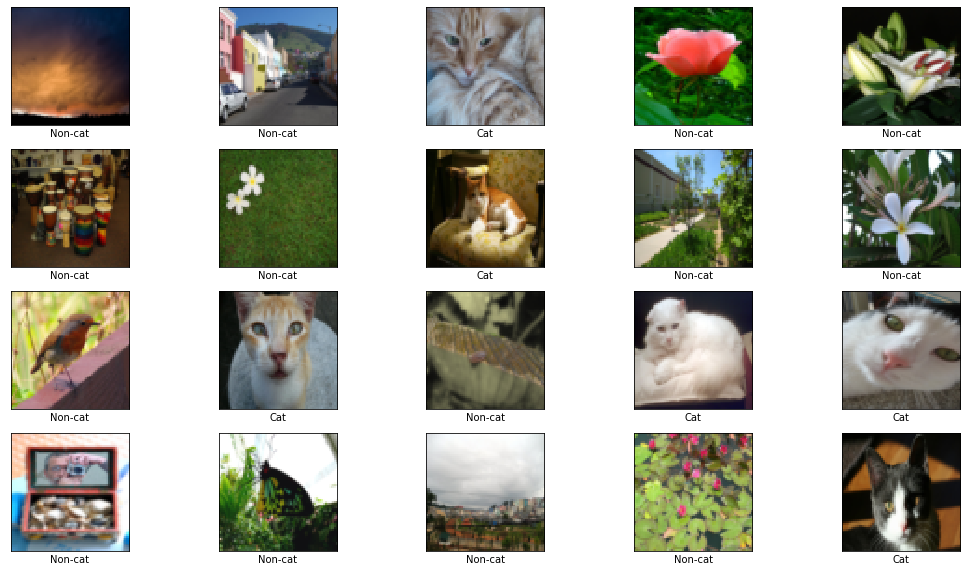

In [185]:
# Plot 20 photos from the training set
plt.figure(figsize=(18,10))

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imgs[i], cmap=plt.cm.binary)
    if y_train[0,i] == 1.:
        plt.xlabel("Cat")
    else:
        plt.xlabel("Non-cat")
    
;

In [156]:
model = NN(X_train, y_train, [5,2,1], beta1=0.9, beta2=0.999, learning_rate=0.00007,
           num_iterations=1500,optimizer=True, lambd=6, seed=0)


In [157]:
model.train()

cost after epoch 0: 0.014603563115166992
cost after epoch 500: 0.008059396716321703
cost after epoch 1000: 0.0072048229568860865


In [160]:
pred = model.predict(X_train, y_train)
pred

array([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [161]:
print("Train accuracy:", accuracy(pred, y_train))

Train accuracy: 0.9712918660287081


In [181]:
pred2 = model.predict(X_test, y_test)
pred2

array([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0]])

In [182]:
print("Test accuracy:", accuracy(pred, y_test))

Test accuracy: 0.74


In [183]:
imgs2 = X_test.T.reshape((50, 64, 64, 3))

''

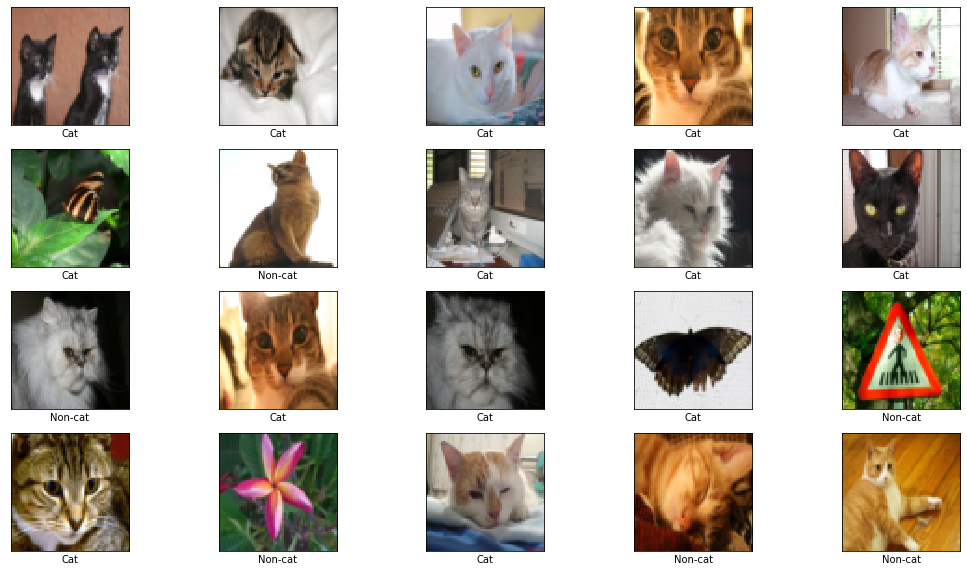

In [184]:
# Plot 20 photos with the predicted labels
plt.figure(figsize=(18,10))

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imgs2[i], cmap=plt.cm.binary)
    if pred[0,i] == 1.:
        plt.xlabel("Cat")
    else:
        plt.xlabel("Non-cat")
    
;

## Done :D